## Imports

In [22]:
import time
from jax import random
import dataset_sines_infinite
import dataset_sines_finite
import dataset_lines_infinite
import dataset_quads_infinite
import dataset_multi_infinite
import test
import plots
import ntk
import nll
from jax import numpy as np

import pickle
import models
import utils
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

from jax.lax import scan
from jax import grad
from jax.tree_util import tree_map
from functools import partial

In [2]:
key = random.PRNGKey(0)

2022-08-27 14:46:23.114933: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/pkgs/cudatoolkit-11.3.1-h2bc3f7f_2/lib
2022-08-27 14:46:23.114979: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
def ci95(array):
    sample_std = np.std(array)
    sample_size = array.shape[0]
    return 0.95 * sample_std / np.sqrt(sample_size)

## Loading results

In [4]:
with open("logs_final/multi_mixture_fim.pickle", "rb") as handle:
    output_fim_mixture = pickle.load(handle)

In [5]:
with open("logs_final/multi_single_fim.pickle", "rb") as handle:
    output_fim_single = pickle.load(handle)

In [6]:
with open("logs_final/maml_mixed.pickle", "rb") as handle:
    output_maml_mixed = pickle.load(handle)

## Loading network

In [7]:
model = models.small_network(40, "relu", 1)
apply_fn = utils.apply_fn_wrapper(model.apply, False)

## Computing kernels

In [9]:
kernel1_fim_mixture, kernel1_self_fim_mixture, jac_fim_mixture = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_fim_mixture["trained_params"], output_fim_mixture["trained_scale1"], output_fim_mixture["trained_batch_stats"], output_fim_mixture["proj1"])
kernel2_fim_mixture, kernel2_self_fim_mixture, jac_fim_mixture = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_fim_mixture["trained_params"], output_fim_mixture["trained_scale2"], output_fim_mixture["trained_batch_stats"], output_fim_mixture["proj2"])

In [10]:
kernel_fim_single, kernel_self_fim_single, jac_fim_single = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_fim_single["trained_params"], output_fim_single["trained_scale"], output_fim_single["trained_batch_stats"], output_fim_single["proj"])

## AUC

In [11]:
def true_score_mixed(nll_sines, nll_lines, nll_quad):
    y_true = np.ones( (nll_sines.shape[0] + nll_lines.shape[0] + nll_quad.shape[0]) )
    y_true = y_true.at[:nll_sines.shape[0]].set(np.array([0]*nll_sines.shape[0]))
    y_true = y_true.at[nll_sines.shape[0]:nll_sines.shape[0]+nll_lines.shape[0]].set(np.array([0]*nll_lines.shape[0]))

    y_score = np.append(nll_sines, nll_lines)
    y_score = np.append(y_score, nll_quad)

    return y_true, y_score

def compute_auc(nll_sines, nll_lines, nll_quad):
    y_true, y_score = true_score_mixed(nll_sines, nll_lines, nll_quad)
    return roc_auc_score(y_true, y_score)

In [18]:
def auc_f_K(key, min_K, max_K):
    Ks = range(min_K, max_K)
    aucs_fim_mixture = []
    aucs_fim_single = []

    for K in Ks:
        print(f"Computation for K={K}")
        key, subkey, subkey_1 = random.split(key, 3)
        nll_sine_fim_mixture = test.test_nll_two_kernels(subkey, kernel1_self_fim_mixture, kernel2_self_fim_mixture, jac_fim_mixture, jac_fim_mixture, dataset_sines_infinite.get_test_batch, K=K, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean1=output_fim_mixture["trained_mean1"], current_mean2=output_fim_mixture["trained_mean2"])
        nll_sine_fim_single = test.test_nll_one_kernel(subkey_1, kernel_self_fim_single, jac_fim_single, dataset_sines_infinite.get_test_batch, K=K, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean=output_fim_single["trained_mean"])
        
        nll_line_fim_mixture = test.test_nll_two_kernels(subkey, kernel1_self_fim_mixture, kernel2_self_fim_mixture, jac_fim_mixture, jac_fim_mixture, dataset_lines_infinite.get_test_batch, K=K, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean1=output_fim_mixture["trained_mean1"], current_mean2=output_fim_mixture["trained_mean2"])
        nll_line_fim_single = test.test_nll_one_kernel(subkey_1, kernel_self_fim_single, jac_fim_single, dataset_lines_infinite.get_test_batch, K=K, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean=output_fim_single["trained_mean"])
        
        nll_quad_fim_mixture = test.test_nll_two_kernels(subkey, kernel1_self_fim_mixture, kernel2_self_fim_mixture, jac_fim_mixture, jac_fim_mixture, dataset_quads_infinite.get_test_batch, K=K, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean1=output_fim_mixture["trained_mean1"], current_mean2=output_fim_mixture["trained_mean2"])
        nll_quad_fim_single = test.test_nll_one_kernel(subkey_1, kernel_self_fim_single, jac_fim_single, dataset_quads_infinite.get_test_batch, K=K, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean=output_fim_single["trained_mean"])

        aucs_fim_mixture.append(compute_auc(nll_sine_fim_mixture, nll_line_fim_mixture, nll_quad_fim_mixture))
        aucs_fim_single.append(compute_auc(nll_sine_fim_single, nll_line_fim_single, nll_quad_fim_single))
        
    return Ks, np.array(aucs_fim_mixture), np.array(aucs_fim_single)

In [19]:
key = random.PRNGKey(0)
Ks, aucs_fim_mixture, aucs_fim_single = auc_f_K(key, 1, 11)

Computation for K=1


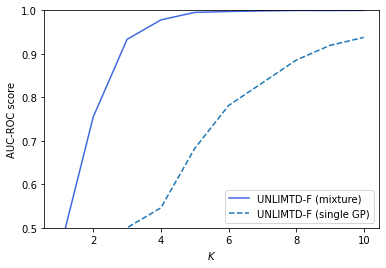

In [36]:
plt.plot(Ks, aucs_fim_mixture, "royalblue", label="UNLIMTD-F (mixture)")
plt.plot(Ks, aucs_fim_single, "--", color="tab:blue", label="UNLIMTD-F (single GP)")
plt.gca().set_ylim([0.5, 1])
plt.gca().set_xlabel("$K$")
plt.gca().set_ylabel("AUC-ROC score")
plt.legend()
plt.savefig("plots/multi_auc.pdf", bbox_inches='tight')

## MSE

### Executing our algorithm

In [24]:
def mse_f_K(key, min_K, max_K):
    Ks = range(min_K, max_K)
    mses_fim_mixture = []
    mses_fim_single = []
    
    ci95s_fim_mixture = []
    ci95s_fim_single = []
    
    for K in Ks:
        print(f"Computation for K={K}")
        key, subkey_1 = random.split(key)
        
        mse_fim_mixture = test.test_error_two_kernels(subkey_1, kernel1_fim_mixture, kernel1_self_fim_mixture, kernel2_fim_mixture, kernel2_self_fim_mixture, jac_fim_mixture, jac_fim_mixture, dataset_quads_infinite.get_test_batch, dataset_quads_infinite.error_fn, K=K, L=100, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean1=output_fim_mixture["trained_mean1"], current_mean2=output_fim_mixture["trained_mean2"])
        mse_fim_single = test.test_error_one_kernel(subkey_1, kernel_fim_single, kernel_self_fim_single, jac_fim_single, dataset_quads_infinite.get_test_batch, dataset_quads_infinite.error_fn, K=K, L=100, n_tasks=1000, data_noise=0.05, maddox_noise=0.05, current_mean=output_fim_single["trained_mean"])
        
        mses_fim_mixture.append(np.mean(mse_fim_mixture))
        ci95s_fim_mixture.append(ci95(mse_fim_mixture))
        
        mses_fim_single.append(np.mean(mse_fim_single))
        ci95s_fim_single.append(ci95(mse_fim_single))

    return Ks, np.array(mses_fim_mixture), np.array(ci95s_fim_mixture), np.array(mses_fim_single), np.array(ci95s_fim_single)

In [25]:
Ks, mses_fim_mixture, ci95s_fim_mixture, mses_fim_single, ci95s_fim_single = mse_f_K(key, 1, 11)

Computation for K=1


### Executing MAML

In [26]:
model = models.small_network(40, "relu", 1)

def apply_fn(params, inputs):
    return model.apply({"params": params}, inputs)

key, key_init0, key_init1 = random.split(key, 3)
batch = dataset_sines_infinite.get_test_batch(key, 10, 10, 10, 0.05)
init_vars = model.init(key_init1, batch[0][0])

In [27]:
# copied from maml_toy.ipynb

def error_fn(predictions, gt):
    return np.mean( (predictions - gt)**2 )

def inner_loss(current_params, x_a, y_a, apply_fn):
    predictions = apply_fn(current_params, x_a)
    
    return error_fn(predictions, y_a)

def inner_updates(current_params, x_a, y_a, n_updates, inner_lr, apply_fn):
    def f(parameters, x):
        inner_gradients = grad(inner_loss)(parameters, x_a, y_a, apply_fn)
        parameters = tree_map(partial(gd_step0, inner_lr), parameters, inner_gradients)
        
        return parameters, None
    
    updated_params, _ = scan(f, current_params, None, n_updates)
    
    return updated_params

def gd_step0(inner_lr, param_value, param_grad):
    return param_value - inner_lr * param_grad

In [28]:
def test_maml(key, apply_fn, params, n_updates_test, inner_lr, n_test_tasks, K, L, noise, error_fn):
    x_a, y_a, x_b, y_b = dataset_multi_infinite.get_test_batch(key, n_test_tasks, K, L, noise)
    
    def f(carry, task):
        x_a, y_a, x_b, y_b = task
        
        updated_params = inner_updates(params, x_a, y_a, n_updates_test, inner_lr, apply_fn)
        predictions = apply_fn(updated_params, x_b)
        
        return None, error_fn(predictions, y_b)
    
    _, errors = scan(f, None, (x_a, y_a, x_b, y_b))
    return errors

In [29]:
config = output_maml_mixed["config"]

def mse_maml_f_K(key, min_K, max_K):
    Ks = range(min_K, max_K)
    mses_maml_mixed = []
    ci95s_maml_mixed = []
    
    for K in Ks:
        print(f"Computation for K={K}")
        key, subkey_1 = random.split(key)
        errors_mixed = test_maml(subkey_1, apply_fn, output_maml_mixed["trained_params"], config["n_updates_test"], config["inner_lr"], 1000, K, 100, 0.05, error_fn)

        mses_maml_mixed.append(np.mean(errors_mixed))
        ci95s_maml_mixed.append(ci95(errors_mixed))

    return Ks, np.array(mses_maml_mixed), np.array(ci95s_maml_mixed)

In [30]:
key, subkey = random.split(key)
Ks, mses_maml_mixed, ci95s_maml_mixed = mse_maml_f_K(key, 1, 11)

Computation for K=1


### MMAML

In [31]:
# Yes, the results are hard-coded
# To obtain these results, train MMAML as explained in readme.md
# Then, test MMAML using the command specified in readme.md
mses_mmaml = np.array( [3.730254, 2.929165, 1.855181, 0.889051, 0.285268, 0.083995, 0.019562, 0.009378, 0.003262, 0.002573])
ci95s_mmaml = np.array( [8.848934e-02, 7.866433e-02, 7.536615e-02, 6.057159e-02, 3.437318e-02, 2.199177e-02, 7.254124e-03, 5.865512e-03, 3.095880e-04, 2.571919e-04])

### Plotting

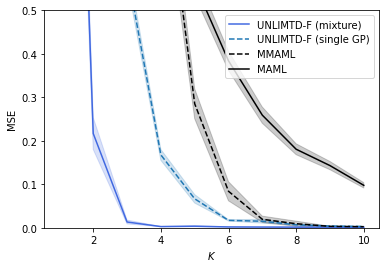

In [33]:
plt.plot(Ks, mses_fim_mixture, "royalblue", label="UNLIMTD-F (mixture)")
plt.fill_between(Ks, mses_fim_mixture - ci95s_fim_mixture, mses_fim_mixture + ci95s_fim_mixture, color='royalblue', alpha=0.2)

plt.plot(Ks, mses_fim_single, "--", color="tab:blue", label="UNLIMTD-F (single GP)")
plt.fill_between(Ks, mses_fim_single - ci95s_fim_single, mses_fim_single + ci95s_fim_single, color='tab:blue', alpha=0.2)

plt.plot(Ks, mses_mmaml, "k--", label="MMAML")
plt.fill_between(Ks, mses_mmaml - ci95s_mmaml, mses_mmaml + ci95s_mmaml, color='k', alpha=0.2)

plt.plot(Ks, mses_maml_mixed, "k", label="MAML")
plt.fill_between(Ks, mses_maml_mixed - ci95s_maml_mixed, mses_maml_mixed + ci95s_maml_mixed, color='k', alpha=0.2)

plt.gca().set_ylim([0, 0.5])
plt.gca().set_xlabel("$K$")
plt.gca().set_ylabel("MSE")
plt.legend()
plt.savefig("plots/multi_mse.pdf", bbox_inches='tight')